In [30]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from stompy.grid import unstructured_grid
import stompy.model.data_comparison as dc
from stompy import utils

import stompy.model.delft.dflow_model as dfm
import pesca_base

import stompy.plot.cmap as scmap
from stompy.plot import plot_utils
turbo=scmap.load_gradient('turbo.cpt')
from matplotlib import cm


In [21]:
import six
six.moves.reload_module(plot_utils)

<module 'stompy.plot.plot_utils' from '/home/rusty/src/stompy/stompy/plot/plot_utils.py'>

In [2]:
%matplotlib notebook

In [22]:
models=[]
for run_dir in ["run_filldrain-v04"]:
    model=dfm.DFlowModel.load(run_dir)
    models.append(model)

<IPython.core.display.Javascript object>


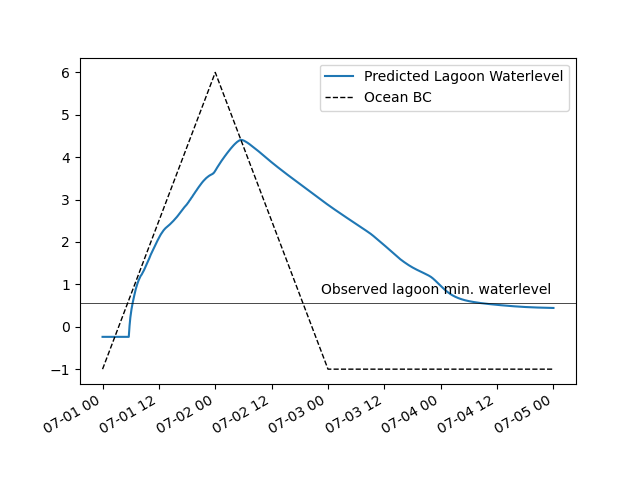

In [29]:
# Read history time series from the various fill-drain
# tests to compare

##
plt.figure(1).clf()
fig,ax=plt.subplots(num=1)

model=models[0]
his_fn=model.his_output()
his_ds=xr.open_dataset(his_fn)

stn_idx=np.nonzero( his_ds.station_name.values==b'lag1')[0][0]

ax.plot(his_ds.time, his_ds.waterlevel.isel(stations=stn_idx),
        label="Predicted Lagoon Waterlevel")

if 1: # Grab BC data from the last one:
    bcs=model.load_bcs()
    ocean=[bc for bc in bcs if bc['name']=='ocean_bc'][0]
    ocean_data=ocean['data']
    ax.plot(ocean_data.time, ocean_data.stage.isel(node=0),
            color='k',lw=1,ls='--',label='Ocean BC')

ax.legend(loc='upper right')

l=ax.axhline(0.55,color='k',lw=0.5)
plot_utils.annotate_line(l,'Observed lagoon min. waterlevel',0.95,
                         ax=ax,ha='right')

fig.autofmt_xdate()

fig.savefig("compare-fill_drain.png")

In [34]:
node_s1=g.interp_cell_to_node(map_ds.s1.isel(time=-1))

<IPython.core.display.Javascript object>


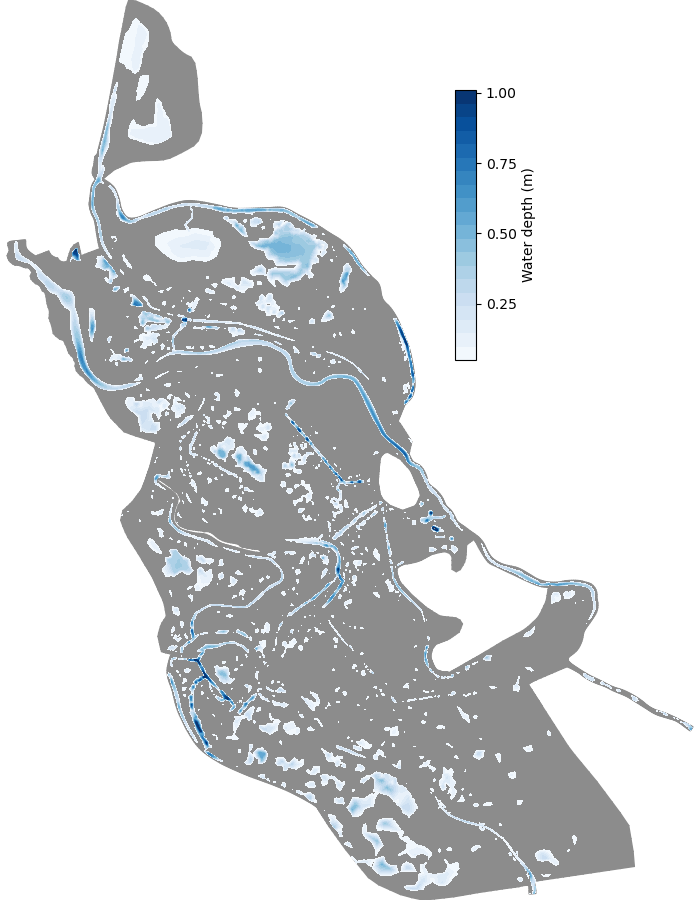

In [55]:
# Plot the final state of the domain:
map_dss=[xr.open_dataset(fn) for fn in model.map_outputs()]
fig=plt.figure(figsize=[7,9])

ax=fig.add_axes([0,0,1,1])
cax=fig.add_axes([0.65,0.6,0.03,0.3])

gray_clip=scmap.cmap_clip(cm.gray,0.3,0.9)
contours=np.linspace(-1,4,64)

wcolls=[]
zcolls=[]

for map_ds in map_dss:
    g=unstructured_grid.UnstructuredGrid.read_ugrid(map_ds)
    
    if 0:
        waterdepth=map_ds.waterdepth.isel(time=-1)
        wcolls.append( g.plot_cells(values=waterdepth,mask=waterdepth>0.01,
                                    cmap=cm.Blues,ax=ax) )
    else:
        # Synthesize node water depths:
        node_s1=g.interp_cell_to_node(map_ds.s1.isel(time=-1).values)
        node_zbed=map_ds.NetNode_z.values
        node_depth=node_s1-node_zbed
        #dry=node_depth<0.01
        #mask=np.all(dry[g.cells['nodes']]
        #node_depth[node_depth<0.01]=np.nan
        wcolls.append( g.contourf_node_values(node_depth,
                                              np.linspace(0.05,1.01,21),
                                              cmap=cm.Blues,
                                              zorder=1,ax=ax))
    zcolls.append( g.plot_cells(color='0.55',ax=ax,zorder=-1) )

ax.axis('tight')
ax.axis('equal')
ax.axis('off')

plt.colorbar(wcolls[0],label='Water depth (m)',cax=cax,
            ticks=[0.0,0.25,0.5,0.75,1.0])

fig.savefig('drained.png')

In [41]:
node_depth.max()

14.635450461823995